---
title: "Stock Market Trend Forecast"
subtitle: "Using Technical Analysis and Machine Learning"
author: "Hoang Son Lai"
categories: [Stock, Technical Analysis, Quantitative Analysis, Machine Learning]
format: 
 html:
  toc: true
  css: styles.css
  embed-resources: true
  code-fold: true
---

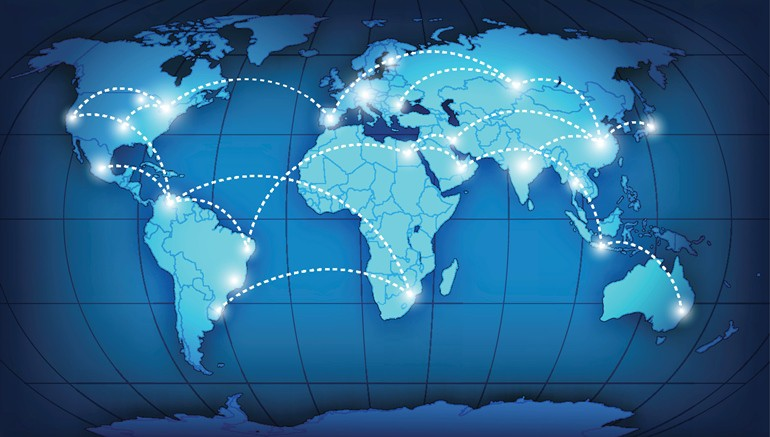

## Data Description

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"
pio.templates.default = "plotly_white"
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
# To convert to html use quarto render ml_report.ipynb

# Load Data
try:
    df = pd.read_csv('report_data/stock_prices.csv')
    df['date'] = pd.to_datetime(df['date'])
    # Sort by Ticker and Date for accurate calculation
    df = df.sort_values(['ticker', 'date'])
except FileNotFoundError:
    print("Error: File 'stock_prices.csv' not found.")

This dataset provides a robust historical record of market performance for 21 unique tickers, spanning from December 7, 2020, to February 3, 2026.

Notably, the data exhibits exceptional quality and balance: every ticker contains exactly 1,295 trading days, ensuring a uniform time-series structure. With 0% missing values and no duplicate entries found, this clean dataset serves as a reliable foundation for technical analysis and algorithmic backtesting.

In [2]:
def describe_market_data(df):
# 1. Basic Structure
    print(f"▶ Total Rows:       {df.shape[0]:,}")
    print(f"▶ Total Columns:    {df.shape[1]}")
    print(f"▶ Column Name: {df.columns}")
    
# 2. Temporal Analysis (Date Range)
    # Ensure date column is datetime
    if 'date' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            try:
                df['date'] = pd.to_datetime(df['date'])
                print("✓ 'date' column converted to datetime format.")
            except:
                print("⚠ Warning: Could not convert 'date' column.")
        
        start_date = df['date'].min().strftime('%Y-%m-%d')
        end_date = df['date'].max().strftime('%Y-%m-%d')
        duration = (df['date'].max() - df['date'].min()).days
        
        print("\nTIME PERIOD:")
        print(f"▶ Start Date:       {start_date}")
        print(f"▶ End Date:         {end_date}")
        print(f"▶ Duration:         {duration} days")
    else:
        print("\n⚠ 'date' column not found!")

    # 3. Ticker Analysis
    if 'ticker' in df.columns:
        unique_tickers = df['ticker'].nunique()
        tickers_list = df['ticker'].unique()
        
        print("\nTICKER STATISTICS:")
        print(f"▶ Unique Tickers:   {unique_tickers}")
        
        # Check for data balance (Top 5 and Bottom 5 tickers by row count)
        ticker_counts = df['ticker'].value_counts()
        print(f"▶ Most Data:        {ticker_counts.index[0]} ({ticker_counts.iloc[0]} rows)")
        print(f"▶ Least Data:       {ticker_counts.index[-1]} ({ticker_counts.iloc[-1]} rows)")
        
        # Example list
        if unique_tickers > 10:
            print(f"▶ Examples:         {', '.join(tickers_list[:5])} ... {', '.join(tickers_list[-5:])}")
        else:
            print(f"▶ List:             {', '.join(tickers_list)}")
    else:
        print("\n⚠ 'ticker' column not found!")

    # 4. Data Quality Check
    print("\nDATA QUALITY CHECK:")
    
    # Missing Values
    missing_data = df.isnull().sum()
    total_cells = np.prod(df.shape)
    total_missing = missing_data.sum()
    
    print(f"▶ Missing Values:   {total_missing:,} cells ({total_missing/total_cells:.2%})")
    
    if total_missing > 0:
        print("  - Columns with most missing values:")
        print(missing_data[missing_data > 0].sort_values(ascending=False).head(5).to_string(header=False))

    # Duplicates Check (assuming Ticker + Date should be unique)
    if 'ticker' in df.columns and 'date' in df.columns:
        duplicates = df.duplicated(subset=['ticker', 'date']).sum()
        if duplicates > 0:
            print(f"⚠ CRITICAL: Found {duplicates} duplicate rows based on Ticker + Date!")
        else:
            print("✓ Integrity Check:  No duplicate (Ticker + Date) pairs found.")
        
describe_market_data(df)

▶ Total Rows:       27,195
▶ Total Columns:    9
▶ Column Name: Index(['id', 'ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='str')

TIME PERIOD:
▶ Start Date:       2020-12-07
▶ End Date:         2026-02-03
▶ Duration:         1884 days

TICKER STATISTICS:
▶ Unique Tickers:   21
▶ Most Data:        AAPL (1295 rows)
▶ Least Data:       WMT (1295 rows)
▶ Examples:         AAPL, ADBE, AMZN, BAC, DIS ... PYPL, TSLA, UNH, V, WMT

DATA QUALITY CHECK:
▶ Missing Values:   0 cells (0.00%)
✓ Integrity Check:  No duplicate (Ticker + Date) pairs found.


## Part 1. Technical Analysis

### 1.1 Objective

The purpose of this section is to evaluate medium-to-long term investment opportunities based on price trends, momentum, and volatility dynamics.

I focus on three key dimensions:

1. Trend Strength – Is the stock in a sustained uptrend?
2. Momentum – Is buying pressure dominant?
3. Volatility – Is the stock stable enough for long-term holding?

To ensure objectivity, I implement a rule-based technical scoring system.


### 1.2 Indicator Calculation

In [3]:
# Work on clean copy
df_tech = df.copy()
df_tech = df_tech.sort_values(['ticker', 'date']).reset_index(drop=True)

# ----- Moving Averages -----

df_tech['SMA50'] = (
    df_tech.groupby('ticker')['close']
    .transform(lambda x: x.rolling(50, min_periods=50).mean())
)

df_tech['SMA200'] = (
    df_tech.groupby('ticker')['close']
    .transform(lambda x: x.rolling(200, min_periods=200).mean())
)

df_tech['EMA50'] = (
    df_tech.groupby('ticker')['close']
    .transform(lambda x: x.ewm(span=50, adjust=False).mean())
)

df_tech['EMA200'] = (
    df_tech.groupby('ticker')['close']
    .transform(lambda x: x.ewm(span=200, adjust=False).mean())
)

# ----- RSI -----
df_tech['RSI'] = (
    df_tech.groupby('ticker')['close']
    .transform(lambda x: ta.rsi(x, length=14))
)

# ----- MACD -----
macd_df = (
    df_tech.groupby('ticker')['close']
    .apply(lambda x: ta.macd(x))
)

# macd_df returns multi-index → fix it safely
macd_df = macd_df.reset_index(level=0, drop=True)

df_tech[['MACD','MACD_signal','MACD_hist']] = macd_df.values

# ----- ATR -----
df_tech['ATR'] = (
    df_tech.groupby('ticker')
    .apply(lambda x: ta.atr(x['high'], x['low'], x['close'], length=14))
    .reset_index(level=0, drop=True)
)

# Final sanity check
print(df_tech.columns)

Index(['id', 'ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close',
       'volume', 'SMA50', 'SMA200', 'EMA50', 'EMA200', 'RSI', 'MACD',
       'MACD_signal', 'MACD_hist', 'ATR'],
      dtype='str')


### 1.3 Technical Scoring Framework

To objectively rank stocks, I construct a rule-based scoring model.

Scoring Rules (Max Score = 7):

• Price > SMA200 → +2 points (Long-term uptrend)

• SMA50 > SMA200 → +2 points (Bullish structure)

• RSI between 40-70 → +1 point (Healthy momentum)

• MACD Histogram > 0 → +1 point (Positive momentum)

• ATR Stability (below median volatility) → +1 point

Higher scores indicate stronger technical positioning.


In [4]:
# ============================================
# TECHNICAL SCORING
# ============================================

# Select latest available row per ticker (after indicators exist)

latest_data = (
    df_tech
    .dropna(subset=['SMA200','SMA50','RSI','MACD_hist','ATR'])
    .sort_values(['ticker','date'])
    .groupby('ticker', as_index=False)
    .last()
    .copy()
)

# Volatility benchmark (cross-sectional)
atr_median = latest_data['ATR'].median()

# Initialize score
latest_data['Technical_Score'] = 0

# ---- Rule 1: Price above long-term trend
latest_data.loc[
    latest_data['close'] > latest_data['SMA200'],
    'Technical_Score'
] += 2

# ---- Rule 2: Bullish structure
latest_data.loc[
    latest_data['SMA50'] > latest_data['SMA200'],
    'Technical_Score'
] += 2

# ---- Rule 3: Healthy RSI
latest_data.loc[
    (latest_data['RSI'] >= 40) & (latest_data['RSI'] <= 70),
    'Technical_Score'
] += 1

# ---- Rule 4: Positive MACD momentum
latest_data.loc[
    latest_data['MACD_hist'] > 0,
    'Technical_Score'
] += 1

# ---- Rule 5: Controlled volatility
latest_data.loc[
    latest_data['ATR'] <= atr_median,
    'Technical_Score'
] += 1

# Final ranking table
technical_ranking = (
    latest_data
    .sort_values('Technical_Score', ascending=False)
    [['ticker','close', 'SMA50', 'SMA200', 'RSI', 'MACD_hist', 'ATR', 'Technical_Score']]
    .reset_index(drop=True)
)

technical_ranking

ticker   close       SMA50      SMA200        RSI  MACD_hist        ATR  \
0    AMZN  238.62  233.274100  222.425575  51.198755   2.039224   6.053808   
1    NVDA  180.34  183.782196  168.491042  42.391106   0.815143   5.597714   
2    AAPL  269.48  268.377900  237.103949  61.636835  -3.441044   5.765347   
3   GOOGL  339.71  320.154600  236.203420  64.105139   6.357234   8.368614   
4     BAC   54.45   53.986840   48.898590  55.862879  -0.471864   1.048584   
5     WMT  127.71  114.708594  103.253056  76.447986   1.785355   2.616339   
6     JNJ  233.10  211.163848  178.965902  82.026191   4.899538   3.892701   
7      KO   76.89   71.059170   69.281143  78.416240   0.859098   1.146067   
8    TSLA  421.96  444.332000  378.959250  42.563691  -5.225154  15.458963   
9      PG  155.32  145.440000  152.819129  69.742452   1.393156   2.478446   
10    JPM  314.85  313.151182  292.761947  54.389592  -3.220069   6.425779   
11   META  691.70  652.100592  682.936129  57.504251   6.605150  21.536002   
12     HD  381.10  359.417390  371.621189  59.689703   6.162209   8.533124   
13    UNH  284.18  328.357800  324.680500  31.476260  -5.584883  11.686519   
14    DIS  104.22  110.071340  112.086058  34.147289  -0.164402   2.681529   
15   PYPL   41.70   58.554700   66.876582  12.836237  -1.689025   2.000723   
16     MA  550.72  553.051426  562.910517  52.057440  -6.982307  11.509197   
17      V  328.93  337.682600  344.115333  45.092224  -4.017751   6.977140   
18   NFLX   79.94   93.601890  112.670533  21.281703  -3.242627   2.370632   
19   ADBE  271.93  326.486100  355.650525  23.304216 -11.383082   9.439230   
20   MSFT  411.21  473.257800  485.250086  27.376590  -8.355396  13.155867   

    Technical_Score  
0                 7  
1                 7  
2                 6  
3                 6  
4                 6  
5                 6  
6                 6  
7                 6  
8                 5  
9                 5  
10                5  
11                4  
12                4  
13                2  
14                1  
15                1  
16                1  
17                1  
18                1  
19                0  
20                0


A stock is considered technically strong and suitable for medium-to-long term holding if:

- Price consistently above SMA200 

- Golden cross structure (SMA50 > SMA200)  

- RSI within 40–70 range  

- Positive MACD histogram  

- Moderate ATR  

Stocks scoring 6–7 points represent high-conviction technical candidates.


### 1.4 Interactive Technical Charts

The following interactive dashboards provide a comprehensive visualization of each stock’s technical condition:

- Price Action – Historical closing prices to observe overall movement and structure

- Trend Indicators – 50-day and 200-day Simple Moving Averages (SMA50 & SMA200) to evaluate long-term trend direction

- Momentum (RSI) – Relative Strength Index to assess overbought and oversold conditions

- MACD & Histogram – Momentum acceleration and trend confirmation signals

Users can dynamically switch between tickers using the dropdown menu located at the top-left of each chart.

These interactive visualizations enhance analytical depth by allowing cross-sectional comparison across stocks and supporting clearer interpretation of trend strength, momentum shifts, and potential entry signals.


In [5]:
df_plot = df_tech.copy() 
df_plot['date'] = pd.to_datetime(df_plot['date']) 
df_plot = df_plot.sort_values(['ticker', 'date']) 
tickers = df_plot['ticker'].unique()

# Ensure datetime
df_plot['date'] = pd.to_datetime(df_plot['date'])

# Get full date range for padding
min_date = df_plot['date'].min()
max_date = df_plot['date'].max()
date_padding = pd.Timedelta(days=10)

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    row_heights=[0.5, 0.25, 0.25],
    subplot_titles=("Price & Moving Averages", "RSI", "MACD")
)

TRACES_PER_TICKER = 7
visibility_matrix = []

for i, ticker in enumerate(tickers):

    data = df_plot[df_plot['ticker'] == ticker]
    visible = [False] * (len(tickers) * TRACES_PER_TICKER)
    base = i * TRACES_PER_TICKER
    for j in range(TRACES_PER_TICKER):
        visible[base + j] = True
    visibility_matrix.append(visible)

    # ================= PRICE =================
    fig.add_trace(go.Scatter(
        x=data['date'], y=data['close'],
        mode='lines',
        name='Close',
        legendgroup=f'price_{ticker}',
        legend='legend1',
        visible=(i==0),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Close: %{y:.2f}<extra></extra>"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=data['date'], y=data['SMA50'],
        mode='lines',
        name='SMA50',
        legendgroup=f'price_{ticker}',
        legend='legend1',
        visible=(i==0),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>SMA50: %{y:.2f}<extra></extra>"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=data['date'], y=data['SMA200'],
        mode='lines',
        name='SMA200',
        legendgroup=f'price_{ticker}',
        legend='legend1',
        visible=(i==0),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>SMA200: %{y:.2f}<extra></extra>"
    ), row=1, col=1)

    # ================= RSI =================
    fig.add_trace(go.Scatter(
        x=data['date'], y=data['RSI'],
        mode='lines',
        name='RSI',
        legendgroup=f'rsi_{ticker}',
        legend='legend2',
        visible=(i==0),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>RSI: %{y:.2f}<extra></extra>"
    ), row=2, col=1)

    # ================= MACD =================
    fig.add_trace(go.Scatter(
        x=data['date'], y=data['MACD'],
        mode='lines',
        name='MACD',
        legendgroup=f'macd_{ticker}',
        legend='legend3',
        visible=(i==0),
        line=dict(color='blue'),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>MACD: %{y:.4f}<extra></extra>"
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        x=data['date'], y=data['MACD_signal'],
        mode='lines',
        name='Signal',
        legendgroup=f'macd_{ticker}',
        legend='legend3',
        visible=(i==0),
        line=dict(color='orange'),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Signal: %{y:.4f}<extra></extra>"
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        x=data['date'], y=data['MACD_hist'],
        mode='lines',
        name='Histogram',
        legendgroup=f'macd_{ticker}',
        legend='legend3',
        visible=(i==0),
        line=dict(color='red', dash='dot'),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Histogram: %{y:.4f}<extra></extra>"
    ), row=3, col=1)

# Dropdown
buttons = []
for i, ticker in enumerate(tickers):
    buttons.append(dict(
        label=ticker,
        method="update",
        args=[
            {"visible": visibility_matrix[i]},
            {"title": f"{ticker} - Technical Dashboard"}
        ]
    ))

# Reference lines
fig.add_hline(y=70, line_dash="dash", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", row=2, col=1)
fig.add_hline(y=0, line_dash="dash", row=3, col=1)

fig.update_layout(
    height=1000,
    hovermode="x unified",

    legend1=dict(x=1.02, y=0.92, xanchor="left"),
    legend2=dict(x=1.02, y=0.55, xanchor="left"),
    legend3=dict(x=1.02, y=0.18, xanchor="left"),

    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=0.01,
        y=1.08,
        xanchor="left",
        yanchor="top"
    )],

    margin=dict(l=60, r=160, t=80, b=60)
)

# Add padding so first & last dates are visible
fig.update_xaxes(
    type="date",
    range=[min_date - date_padding, max_date + date_padding]
)

fig.show()

## Part 2. Quantitative Analysis

### 2.1 Objective

The purpose of this section is to evaluate each stock from a quantitative investment perspective by measuring:

- Historical return
- Risk exposure
- Risk-adjusted performance

Unlike technical indicators, which focus on timing and momentum, quantitative metrics evaluate structural performance over the medium-to-long term.

This section aims to identify stocks that not only generate strong returns, but do so efficiently relative to risk.


### 2.2. Historical Returns

Return measures how much value an investment generates over time. I evaluate:

- Daily Return

- Total Return

- CAGR (Compound Annual Growth Rate)

CAGR is especially important for medium–long term investors because it smooths volatility and shows the true annual growth rate.

In [6]:
# Ensure proper datetime format
df = df_tech.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])

# -----------------------------
# Daily Returns
# -----------------------------
df['daily_return'] = df.groupby('ticker')['adj_close'].pct_change()

# -----------------------------
# Cumulative Returns
# -----------------------------
df['cum_return'] = ( df.groupby('ticker')['daily_return'] .transform(lambda x: (1 + x).cumprod()) )

# Ensure datetime format
df['date'] = pd.to_datetime(df['date'])
# Get full date range for padding
min_date = df['date'].min()
max_date = df['date'].max()
date_padding = pd.Timedelta(days=10)

# Get latest cumulative return for each ticker
latest_perf = (
    df.sort_values('date')
      .groupby('ticker')
      .tail(1)[['ticker', 'cum_return']]
      .sort_values('cum_return', ascending=False)
)

ordered_tickers = latest_perf['ticker'].tolist()

df['ticker'] = pd.Categorical(
    df['ticker'],
    categories=ordered_tickers,
    ordered=True
)

df = df.sort_values(['ticker', 'date'])

# Build figure
fig_cum = px.line(
    df,
    x='date',
    y='cum_return',
    color='ticker',
    category_orders={"ticker": ordered_tickers},
    title='Cumulative Return Over Time'
)

# Force daily format + unified hover
fig_cum.update_traces(
    hovertemplate=
    "<b>%{fullData.name}</b><br>" +
    "Date: %{x|%Y-%m-%d}<br>" +
    "Cumulative Return: %{y:.2f}<extra></extra>"
)

fig_cum.update_layout(
    height=500,
    yaxis_title="Cumulative Return (Growth of $1)",
    xaxis_title="Date",
    legend_title="Ticker",
    xaxis=dict(
        type="date",
        hoverformat="%Y-%m-%d"
    )
)

# Add padding so first & last dates are visible
fig.update_xaxes(
    type="date",
    range=[min_date - date_padding, max_date + date_padding]
)

fig_cum.show()

In [7]:
# -----------------------------
# Total Return
# -----------------------------
total_return = (
    df.groupby('ticker')['adj_close']
    .agg(lambda x: x.iloc[-1] / x.iloc[0] - 1)
    .reset_index(name='Total Return')
)

# -----------------------------
# CAGR
# -----------------------------
years = (df['date'].max() - df['date'].min()).days / 365

cagr = (
    df.groupby('ticker')['adj_close']
    .agg(lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / years) - 1)
    .reset_index(name='CAGR')
)

mean_daily = (
    df.groupby('ticker')['daily_return']
    .mean()
    .reset_index(name='Mean Daily Return')
)

# -----------------------------
# Mean Daily Return
# -----------------------------

mean_daily = (
    df.groupby('ticker')['daily_return']
    .mean()
    .reset_index(name='Mean Daily Return')
)

# -----------------------------
# Merge All Return Metrics
# -----------------------------

return_table = (
    total_return
    .merge(mean_daily, on='ticker')
    .merge(cagr, on='ticker')
)

# -----------------------------
# Display Table
# -----------------------------

return_table.sort_values('CAGR', ascending=False)\
    .style.format({
        'Total Return': '{:.2%}',
        'Mean Daily Return': '{:.4%}',
        'CAGR': '{:.2%}'
    })

### 2.3 Risk Analysis

Next, I evaluate:

- Volatility (annualized). 

Volatility measures the dispersion of daily returns around their mean. It reflects how much the price fluctuates over time. Calculated as the standard deviation of daily returns. Annualized by multiplying by √252 (trading days per year)

Volatility captures total risk, but it does not distinguish between upside and downside movements.

- Max Drawdown

Maximum Drawdown measures the largest peak-to-trough decline during the investment period. It answers the question: "What was the worst loss an investor would have experienced if they bought at the worst possible time?"

- Downside Deviation

Downside Deviation measures only the volatility of negative returns. Unlike standard volatility, it ignores upside movements and focuses purely on harmful price drops.

In [8]:
# -----------------------------
# Annualized Volatility
# -----------------------------
volatility = (
    df.groupby('ticker')['daily_return']
    .std()
    .reset_index(name='Volatility')
)

volatility['Volatility'] *= np.sqrt(252)

# -----------------------------
# Max Drawdown
# -----------------------------
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = cumulative / peak - 1
    return drawdown.min()

max_dd = (
    df.groupby('ticker')['daily_return']
    .apply(max_drawdown)
    .reset_index(name='Max Drawdown')
)

# -----------------------------
# Downside Deviation
# -----------------------------
def downside_dev(series):
    negative_returns = series[series < 0]
    return negative_returns.std() * np.sqrt(252)

downside = (
    df.groupby('ticker')['daily_return']
    .apply(downside_dev)
    .reset_index(name='Downside Deviation')
)

risk_table = volatility.merge(max_dd, on='ticker') \
                       .merge(downside, on='ticker')

risk_table.sort_values('Volatility', ascending=False)


ticker  Volatility  Max Drawdown  Downside Deviation
8    TSLA    0.603882     -0.736322            0.386416
0    NVDA    0.516043     -0.663351            0.321509
4    META    0.432483     -0.767361            0.327562
14   NFLX    0.429039     -0.759473            0.346927
20   PYPL    0.423023     -0.864531            0.334133
19   ADBE    0.351307     -0.604965            0.287713
15   AMZN    0.348523     -0.561453            0.240462
1   GOOGL    0.308206     -0.443201            0.208750
17    UNH    0.307217     -0.613909            0.285874
18    DIS    0.297558     -0.607151            0.211988
5    AAPL    0.278297     -0.333605            0.187846
6     BAC    0.269460     -0.466430            0.179367
7    MSFT    0.260219     -0.371485            0.181007
2     JPM    0.242782     -0.387716            0.171216
11     MA    0.241729     -0.282503            0.173594
12     HD    0.235640     -0.347293            0.163392
13      V    0.226831     -0.286045            0.162837
3     WMT    0.208425     -0.257398            0.162114
16     PG    0.172567     -0.237725            0.126769
9     JNJ    0.167809     -0.184117            0.113472
10     KO    0.159440     -0.172748            0.112043

In [9]:
risk_return = return_table.merge(risk_table, on='ticker')

fig_scatter = px.scatter(
    risk_return,
    x='Volatility',
    y='CAGR',
    text='ticker',
    title='Risk vs Return (CAGR vs Volatility)'
)

fig_scatter.update_traces(
    textposition='top center',
    marker=dict(size=12),
    hovertemplate=
        "<b>%{text}</b><br>" +
        "CAGR: %{y:.2%}<br>" +
        "Volatility: %{x:.2%}<br>" +
        "Max Drawdown: %{customdata[0]:.2%}<br>" +
        "<extra></extra>",
    customdata=risk_return[['Max Drawdown']]
)

fig_scatter.update_layout(
    height=500,
    hovermode="closest"
)

fig_scatter.show()



### 2.4. Risk-Adjusted Performance

Next, I compute Sharpe Ratio, Sortino Ratio, and Calmar Ratio

- The Sharpe Ratio measures how much excess return an investment generates for each unit of total risk taken. It is calculated as the difference between the portfolio return and the risk-free rate, divided by total volatility (standard deviation of returns). A higher Sharpe Ratio indicates better risk-adjusted performance, meaning the investor is being compensated more efficiently for the overall risk assumed.

- The Sortino Ratio is a refinement of the Sharpe Ratio that penalizes only downside risk rather than total volatility. Instead of using total standard deviation, it uses downside deviation (volatility of negative returns). This makes it particularly useful for equity investors, as it focuses on harmful volatility. A higher Sortino Ratio indicates stronger returns relative to downside risk.

- The Calmar Ratio evaluates performance relative to maximum drawdown. It is calculated as the compound annual growth rate (CAGR) divided by the absolute value of maximum drawdown. This metric is especially important for medium- to long-term investors because it measures how efficiently a strategy generates returns while controlling large capital losses. A higher Calmar Ratio indicates better return relative to worst historical drawdown.

In [10]:
risk_free_rate = 0.02

metrics = risk_return.copy()

# Sharpe
metrics['Sharpe'] = (
    (metrics['CAGR'] - risk_free_rate) / metrics['Volatility']
)

# Sortino
metrics['Sortino'] = (
    (metrics['CAGR'] - risk_free_rate) / metrics['Downside Deviation']
)

# Calmar
metrics['Calmar'] = (
    metrics['CAGR'] / abs(metrics['Max Drawdown'])
)

metrics = metrics[
    ['ticker','CAGR','Volatility','Max Drawdown',
     'Sharpe','Sortino','Calmar']
]

mt = metrics[
    ['ticker','Sharpe','Sortino','Calmar']
]

mt.sort_values('Sharpe', ascending=False)


ticker    Sharpe   Sortino    Calmar
0    NVDA  1.222229  1.961757  0.980964
3     WMT  0.952311  1.224356  0.848823
1   GOOGL  0.885266  1.307038  0.660748
2     JPM  0.875117  1.240899  0.599569
9     JNJ  0.602120  0.890456  0.657416
10     KO  0.542959  0.772645  0.616906
5    AAPL  0.534710  0.792184  0.506012
6     BAC  0.504213  0.757473  0.334167
7    MSFT  0.475393  0.683433  0.386843
4    META  0.389292  0.513986  0.245467
11     MA  0.344916  0.480297  0.365930
12     HD  0.341413  0.492379  0.289238
13      V  0.334401  0.465820  0.335097
8    TSLA  0.199807  0.312254  0.191030
15   AMZN  0.181574  0.263171  0.148334
16     PG  0.166563  0.226738  0.205041
14   NFLX  0.159890  0.197734  0.116659
17    UNH -0.144457 -0.155242 -0.039712
18    DIS -0.300797 -0.422214 -0.114476
19   ADBE -0.366086 -0.447003 -0.179528
20   PYPL -0.694524 -0.879291 -0.316704

### 2.5. Quantitative Scoring

To make stock comparison clearer and more objective, I combine multiple performance and risk indicators into a single Quantitative Score ranging from 0 to 10. Instead of evaluating return, volatility, drawdown, and Sharpe ratio separately, this model summarizes them into one number. This makes ranking stocks easier and reduces subjective judgment.

Because each metric is measured on a different scale, I first standardize them using min–max normalization. This converts every metric into a comparable 0–1 range. For metrics where higher is better (such as CAGR and Sharpe ratio), higher values receive higher normalized scores. For risk metrics (such as volatility and maximum drawdown), the scale is reversed so that lower risk results in a higher score.

Next, I assign weights to reflect investment priorities. In this framework, growth and efficiency are more important than pure stability. Therefore, I allocate 40% weight to CAGR, 30% to Sharpe ratio, 20% to volatility control, and 10% to maximum drawdown. This weighting structure emphasizes sustainable long-term compounding while still penalizing excessive risk exposure.

After applying the weights, I sum the components and scale the result to a 0–10 range. A higher score indicates stronger overall quantitative performance, meaning the stock delivers attractive returns with controlled risk. Scores closer to 10 represent a well-balanced and efficient risk-return profile.

In [11]:
# Step 1 – Normalize Metrics (Min–Max)
score_df = metrics.copy()

def minmax(series):
    return (series - series.min()) / (series.max() - series.min())

score_df['Return_score'] = minmax(score_df['CAGR'])
score_df['Sharpe_score'] = minmax(score_df['Sharpe'])
score_df['Vol_score'] = 1 - minmax(score_df['Volatility'])
score_df['DD_score'] = 1 - minmax(abs(score_df['Max Drawdown']))

# Step 2 – Weighted Quant Score
score_df['Quant Score'] = (
    0.4 * score_df['Return_score'] +
    0.3 * score_df['Sharpe_score'] +
    0.2 * score_df['Vol_score'] +
    0.1 * score_df['DD_score']
)

score_df['Quant Score'] *= 10

score_df = score_df.sort_values('Quant Score', ascending=False)

score_df[['ticker','Quant Score']]

# Step 3 - Quant Score Ranking 
# Round values for presentation
display_table = score_df.copy()

display_table = display_table[[
    'ticker',
    'CAGR',
    'Volatility',
    'Max Drawdown',
    'Sharpe',
    'Return_score',
    'Sharpe_score',
    'Vol_score',
    'DD_score',
    'Quant Score'
]]

display_table = display_table.round(3)

display_table = display_table.sort_values('Quant Score', ascending=False)

display_table

ticker   CAGR  Volatility  Max Drawdown  Sharpe  Return_score  \
0    NVDA  0.651       0.516        -0.663   1.222         1.000   
3     WMT  0.218       0.208        -0.257   0.952         0.532   
2     JPM  0.232       0.243        -0.388   0.875         0.548   
1   GOOGL  0.293       0.308        -0.443   0.885         0.613   
9     JNJ  0.121       0.168        -0.184   0.602         0.427   
10     KO  0.107       0.159        -0.173   0.543         0.411   
5    AAPL  0.169       0.278        -0.334   0.535         0.479   
7    MSFT  0.144       0.260        -0.371   0.475         0.452   
6     BAC  0.156       0.269        -0.466   0.504         0.465   
13      V  0.096       0.227        -0.286   0.334         0.400   
11     MA  0.103       0.242        -0.283   0.345         0.408   
12     HD  0.100       0.236        -0.347   0.341         0.405   
16     PG  0.049       0.173        -0.238   0.167         0.349   
4    META  0.188       0.432        -0.767   0.389         0.500   
15   AMZN  0.083       0.349        -0.561   0.182         0.386   
14   NFLX  0.089       0.429        -0.759   0.160         0.392   
17    UNH -0.024       0.307        -0.614  -0.144         0.270   
8    TSLA  0.141       0.604        -0.736   0.200         0.448   
18    DIS -0.070       0.298        -0.607  -0.301         0.221   
19   ADBE -0.109       0.351        -0.605  -0.366         0.179   
20   PYPL -0.274       0.423        -0.865  -0.695         0.000   

    Sharpe_score  Vol_score  DD_score  Quant Score  
0          1.000      0.198     0.291        7.686  
3          0.859      0.890     0.878        7.365  
2          0.819      0.812     0.689        6.961  
1          0.824      0.665     0.609        6.864  
9          0.676      0.981     0.984        6.684  
10         0.646      1.000     1.000        6.583  
5          0.641      0.733     0.767        6.072  
7          0.610      0.773     0.713        5.897  
6          0.625      0.752     0.575        5.816  
13         0.537      0.848     0.836        5.743  
11         0.542      0.815     0.841        5.730  
12         0.540      0.829     0.748        5.645  
16         0.449      0.970     0.906        5.590  
4          0.565      0.386     0.140        4.608  
15         0.457      0.575     0.438        4.503  
14         0.446      0.393     0.152        3.844  
17         0.287      0.667     0.362        3.637  
8          0.467      0.000     0.185        3.378  
18         0.205      0.689     0.372        3.251  
19         0.171      0.568     0.375        2.741  
20         0.000      0.407     0.000        0.814

## Part 3. Machine Learning

### 3.1. Objective

The goal of this section is not to predict exact future prices.

Instead, I aim to:

• Forecast future trend

• Estimate expected return

• Predict direction (up/down)

• Convert predictions into an ML investment signal

This approach is more realistic and aligned with quantitative investing practice.

### 3.2. Feature Engineering

Feature engineering is the most important part of ML in finance. I construct predictive variables based on:

**Momentum & Trend**

- Lag returns (1, 5, 10, 20 days)

- RSI

- MACD

- ATR

**Long-Term Structure**

- Price / SMA200 ratio

**Liquidity**

- Volume change

I aim to predict future_return_20d - this represents expected 1-month forward return.

In [28]:
df_ml = df_tech.copy()
df_ml = df_ml.sort_values(['ticker', 'date'])

# =============================
# Create Lag Returns
# =============================

for lag in [1, 5, 10, 20]:
    df_ml[f'return_{lag}d'] = (
        df_ml.groupby('ticker')['close']
        .pct_change(lag)
    )

# =============================
# Volume Change
# =============================

df_ml['volume_change_5d'] = (
    df_ml.groupby('ticker')['volume']
    .pct_change(5)
)

# =============================
# Price / SMA Ratio
# =============================

df_ml['price_sma200_ratio'] = df_ml['close'] / df_ml['SMA200']

# =============================
# Target Variable (20-day forward return)
# =============================

df_ml['future_return_20d'] = (
    df_ml.groupby('ticker')['close']
    .shift(-20) / df_ml['close'] - 1
)

# Drop NA
df_ml = df_ml.dropna()

df_ml.head()

id ticker       date      open      high       low     close  adj_close  \
199  200   AAPL 2021-09-22  141.2759  143.2124  140.5424  142.6451   142.6451   
200  201   AAPL 2021-09-23  143.4275  143.8481  142.4397  143.6036   143.6036   
201  202   AAPL 2021-09-24  142.4593  144.2295  142.3615  143.6916   143.6916   
202  203   AAPL 2021-09-27  142.2735  142.7527  140.6597  142.1757   142.1757   
203  204   AAPL 2021-09-28  140.1022  141.5693  138.5765  138.7917   138.7917   

        volume       SMA50  ...  MACD_signal  MACD_hist       ATR  return_1d  \
199   76404300  144.960510  ...    -1.102816   0.348422  2.864782   0.016873   
200   64838200  144.919494  ...    -0.887100   0.126647  2.760755   0.006719   
201   53477900  144.893324  ...    -0.700928  -0.048585  2.696987   0.000613   
202   74150700  144.877656  ...    -0.643794  -0.209533  2.720909  -0.010550   
203  108972300  144.871262  ...    -0.788283  -0.406604  2.783644  -0.023802   

     return_5d  return_10d  return_20d  volume_change_5d  price_sma200_ratio  \
199  -0.021338   -0.059699   -0.025197         -0.082576            1.088618   
200  -0.013173   -0.046992   -0.010313         -0.046975            1.094966   
201   0.005888   -0.013761   -0.004202         -0.588216            1.094693   
202   0.017000   -0.027950   -0.021736         -0.399487            1.082171   
203  -0.010597   -0.041925   -0.073211          0.436985            1.055657   

     future_return_20d  
199           0.023380  
200           0.018048  
201           0.012047  
202           0.022494  
203           0.052216  

[5 rows x 25 columns]

### 3.3. Model Selection

I choose to use XGBoost Regressor because this model:

- Handles nonlinear relationships

- Robust to multicollinearity

- Performs well on tabular financial data

- Interpretable via feature importance

I use walk-forward split to train on past and test on future.

In [29]:
# ===============================
# Prepare Data (Sort First)
# ===============================

df_ml = df_ml.sort_values(['date', 'ticker']).reset_index(drop=True)

# Feature columns
features = [
    'return_1d', 'return_5d', 'return_10d', 'return_20d',
    'RSI', 'MACD', 'ATR',
    'price_sma200_ratio',
    'volume_change_5d'
]

target = 'future_return_20d'


# ===============================
# Time-Based Split
# ===============================

# Determine split date (80% time)
split_date = df_ml['date'].quantile(0.8)

train = df_ml[df_ml['date'] <= split_date].copy()
test  = df_ml[df_ml['date'] > split_date].copy()

print("Train period:", train['date'].min(), "→", train['date'].max())
print("Test period:", test['date'].min(), "→", test['date'].max())

print("Train tickers:", train['ticker'].nunique())
print("Test tickers:", test['ticker'].nunique())


# ===============================
# Train-Test Sets
# ===============================

X_train = train[features]
y_train = train[target]

X_test  = test[features]
y_test  = test[target]


# ===============================
# Model Training
# ===============================

model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


# ===============================
# Prediction
# ===============================

y_pred = model.predict(X_test)

Train period: 2021-09-22 00:00:00 → 2025-02-26 00:00:00
Test period: 2025-02-27 00:00:00 → 2026-01-05 00:00:00
Train tickers: 21
Test tickers: 21


### 3.4. Model Evaluation

We evaluate the model using:

- RMSE: To measure prediction error magnitude.

- Directional Accuracy: To see the percentage of times model correctly predicts direction.

In [30]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Directional Accuracy
direction_actual = np.sign(y_test)
direction_pred = np.sign(y_pred)

directional_accuracy = (direction_actual == direction_pred).mean()

print("RMSE:", round(rmse, 4))
print("Directional Accuracy:", round(directional_accuracy, 4))


RMSE: 0.0906
Directional Accuracy: 0.5316


In [35]:
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

fig = px.scatter(
    results_df,
    x='Actual',
    y='Predicted',
    title='Actual vs Predicted 20-Day Returns'
)

fig.add_shape(
    type='line',
    x0=results_df['Actual'].min(),
    y0=results_df['Actual'].min(),
    x1=results_df['Actual'].max(),
    y1=results_df['Actual'].max()
)

fig.update_layout(height=500)

fig.show()


In [36]:
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

fig_imp = px.bar(
    importance_df,
    x='Feature',
    y='Importance',
    title='Feature Importance'
)

fig_imp.update_layout(height=500)

fig_imp.show()


### 3.5 ML Signal Construction

After generating out-of-sample predictions from the trained XGBoost model, we construct the ML investment signal using the most recent predicted return for each ticker.

Specifically, for each stock, we extract the latest predicted 20-day forward return from the test period. This represents the model’s expected medium-term performance estimate based on current technical and structural features.

To convert predictions into an interpretable ranking metric, we normalize the predicted returns using Min-Max scaling to a standardized 0–10 ML Score:

- Higher predicted return → Higher ML Score

- Lower predicted return → Lower ML Score

This transformation ensures comparability across stocks and allows seamless integration into the final multi-factor scoring framework.

The resulting ML Score does not represent certainty of price movement, but rather the relative strength of expected forward return according to the model.

In [41]:
# Attach predictions
test = test.copy()
test['predicted_return'] = y_pred

# Get latest prediction per ticker
ml_signal = (
    test
    .sort_values('date')
    .groupby('ticker')
    .tail(1)[['ticker', 'predicted_return']]
    .sort_values('predicted_return', ascending=False)
)

ml_signal.reset_index(drop=True)

# Normalize predicted returns:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0, 10))

ml_signal['ML Score'] = scaler.fit_transform(
    ml_signal[['predicted_return']]
)

ml_signal = ml_signal.sort_values('ML Score', ascending=False)

ml_signal

ticker  predicted_return   ML Score
22575   AAPL          0.047584  10.000000
22580  GOOGL          0.047144   9.941805
22588   NFLX          0.039374   8.914421
22595    WMT          0.022049   6.623508
22578    BAC          0.019512   6.287998
22589   NVDA          0.018553   6.161199
22587   MSFT          0.018195   6.113890
22583    JPM          0.017146   5.975072
22581     HD          0.011848   5.274515
22593    UNH          0.011781   5.265734
22577   AMZN          0.010119   5.045922
22591   PYPL          0.007110   4.648088
22586   META          0.006526   4.570768
22582    JNJ          0.006073   4.510870
22579    DIS          0.004332   4.280670
22590     PG          0.003566   4.179348
22584     KO         -0.008488   2.585410
22585     MA         -0.017626   1.377099
22594      V         -0.018471   1.265449
22576   ADBE         -0.025800   0.296191
22592   TSLA         -0.028040   0.000000